## Analyzing Bias images and finding the median bias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pickle

from astropy.io import fits
from astropy.time import Time

In [3]:
bias_list = np.genfromtxt('bias/bias.list', dtype=str)
print(bias_list)

['AF580596.fits' 'AF580597.fits' 'AF580598.fits' 'AF580599.fits'
 'AF580600.fits' 'AF580601.fits' 'AF580602.fits' 'AF580603.fits'
 'AF580604.fits' 'AF580605.fits' 'AF580606.fits' 'AF580607.fits'
 'AF580608.fits' 'AF580609.fits' 'AF580610.fits' 'AF580611.fits'
 'AF580612.fits' 'AF580613.fits' 'AF580614.fits' 'AF580615.fits'
 'AF580616.fits' 'AF580617.fits' 'AF580618.fits' 'AF580619.fits'
 'AF580620.fits' 'AF580621.fits' 'AF580622.fits' 'AF580623.fits'
 'AF580624.fits' 'AF580625.fits']


### Extracting information from a FITS file

In [4]:
bias_fits = fits.open('./bias/' + bias_list[0])
bias_hdu = bias_fits[0]

In [5]:
bias_airmass = bias_hdu.header['AIRMASS']
bias_gain = bias_hdu.header['GAIN']
bias_gain_comment = bias_hdu.header.comments['GAIN']
bias_ron = bias_hdu.header['RDNOISE']
bias_ron_comment = bias_hdu.header.comments['RDNOISE']

bias_time = bias_hdu.header['JD']
t = Time(bias_time, format='jd', scale='utc')

In [6]:
print('CCD Gain : {0:4.2f} {1:8s}'.format(bias_gain, bias_gain_comment) )
print('CCD Read out Noise: {0:4.2f} {1:8s}'.format(bias_ron, bias_ron_comment) )

CCD Gain : 1.91 [e/ADU] CCD Camera gain
CCD Read out Noise: 7.10 [e] CCD Camera readout noise


In [7]:
print('Julian date : {0:12.6f} JD'.format(bias_time))
print('ISO representation: {0}'.format(t.iso))

Julian date : 2458847.465683 JD
ISO representation: 2019-12-29 23:10:35.011


### Understanding the shape of this array

In [8]:
bias_naxis1 = bias_fits[0].header['NAXIS1'] #horizontal axis
bias_naxis2 = bias_fits[0].header['NAXIS2'] #vertical axis
n_images = len(bias_list) #number of images

In [10]:
print('Shape of the FITS image from the header : {0:4d} x {1:4d}'.
      format(bias_naxis1, bias_naxis2))

Shape of the FITS image from the header :  521 x  222


In [11]:
bias_data= bias_fits[0].data * bias_gain

In [12]:
bias_data = bias_hdu.data * bias_gain
bias_array_dim0, bias_array_dim1 = np.shape(bias_data)
print('Shape of the NumPy array extracted by astropy: {0:4d} x {1:4d}'.
      format(bias_array_dim0, bias_array_dim1))
print('Our image is saved as a ', type(bias_data))

Shape of the NumPy array extracted by astropy:  222 x  521
Our image is saved as a  <class 'numpy.ndarray'>


For `bias_data[i,j]`: `[i]` refers to the index of the row, `[j]` refers to the index of the column.

The shape of the numpy array is inverted wrt the FITS file.

### Plotting a single bias

Text(0, 0.5, 'Y (pixels)')

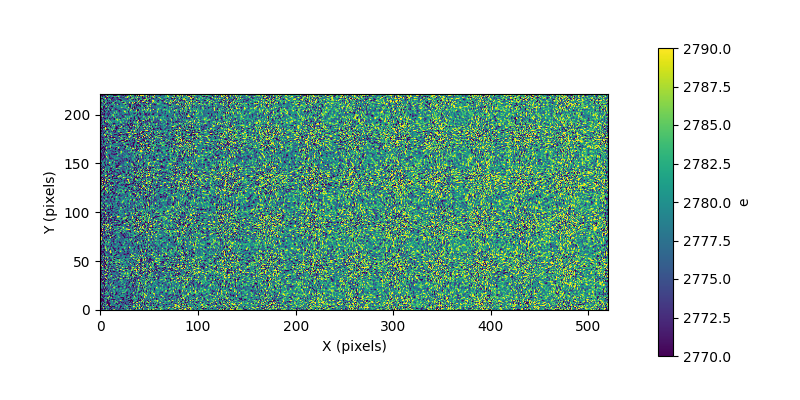

In [17]:
plt.figure(figsize=(8,4))
plt.imshow(bias_data, vmin = 2770, vmax = 2790, origin='lower')
cbar = plt.colorbar(fraction=0.1, pad=0.08)
cbar.set_label('e')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')

### Saving bias frames into 3D array

In [23]:
stack = np.empty([n_images, bias_array_dim0, bias_array_dim1])

In [24]:
for i_bias, bias_name in enumerate(bias_list):
    bias_temp = fits.open('./bias/' + bias_name)
    stack[i_bias,:,:] = bias_temp[0].data * bias_temp[0].header['GAIN']
    bias_temp.close()

In [25]:
median_bias = np.median(stack, axis=0)

### Plotting Median Bias

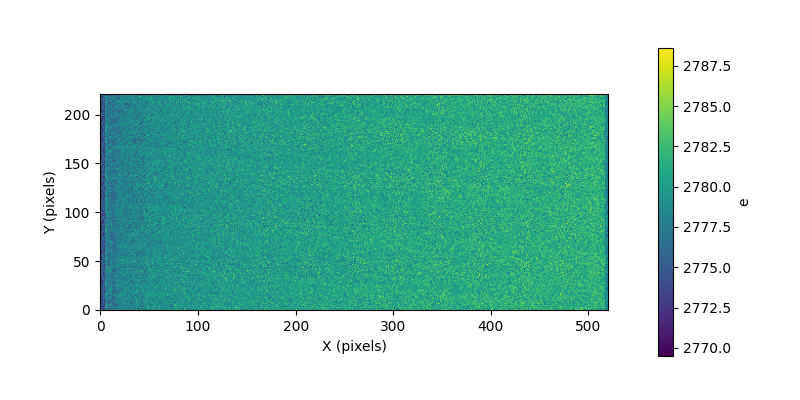

In [28]:
plt.figure(figsize=(8,4))
plt.imshow(median_bias, origin='lower')
cbar = plt.colorbar(fraction=0.1, pad=0.08)
cbar.set_label('e')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)');

In [29]:
max = np.median(bias_data) + 2 * np.std(bias_data)
min = np.median(bias_data) - 2 * np.std(bias_data)

Text(0, 0.5, 'Y[Pixels]')

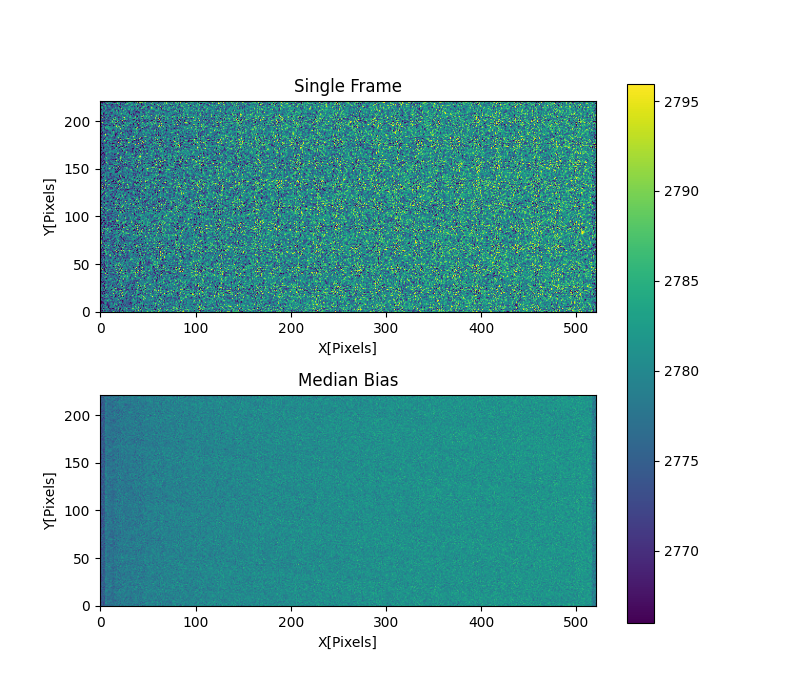

In [36]:
fig, ax = plt.subplots(2,1, figsize=(8,7))
im1 = ax[0].imshow(bias_data, origin='lower', vmin = min, vmax=max)
im2 = ax[1].imshow(median_bias, origin='lower', vmin = min, vmax=max);
cbar = fig.colorbar(im1, ax=ax)

ax[0].set_title('Single Frame')
ax[0].set_xlabel('X[Pixels]')
ax[0].set_ylabel('Y[Pixels]')

ax[1].set_title('Median Bias')
ax[1].set_xlabel('X[Pixels]')
ax[1].set_ylabel('Y[Pixels]')

### Statistical Analysis of the Bias

Bias = combination of electronical offset, and read-out noise.

Due to the horizontal variation, we find the average median bias across each column.

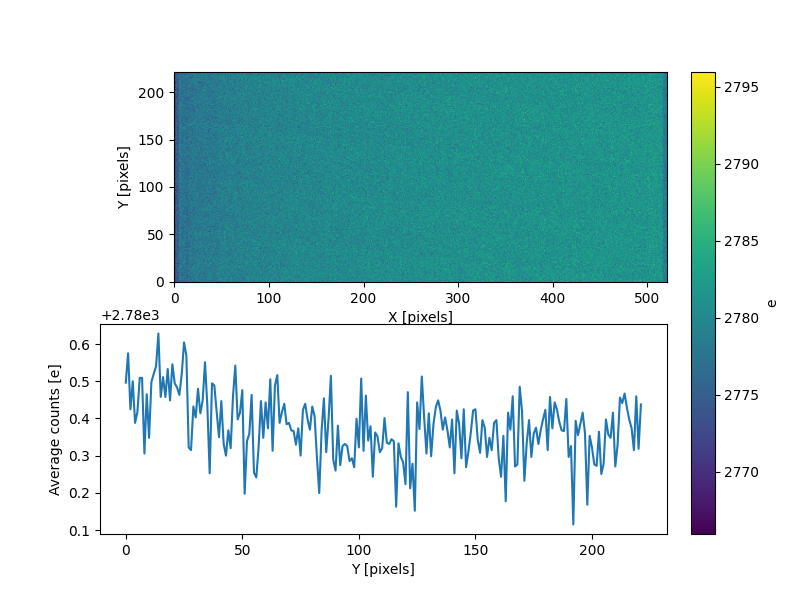

In [37]:
fig, ax = plt.subplots(2,1, figsize = (8,6))
im1 = ax[0].imshow(median_bias, origin='lower', vmin = min, vmax=max)
median_row = np.average(median_bias, axis=1)
im2 = ax[1].plot(median_row)

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")
ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')
ax[1].set_xlabel('Y [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()

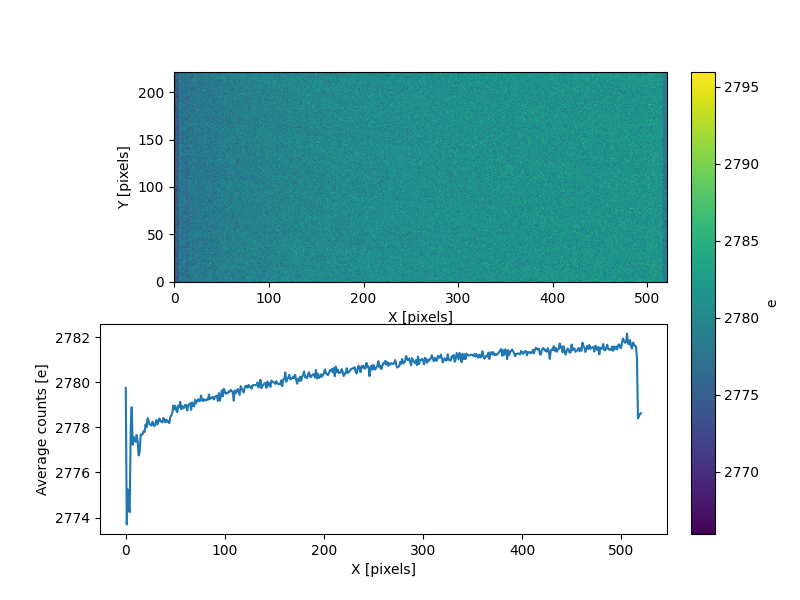

In [38]:
fig, ax = plt.subplots(2,1, figsize = (8,6))
im1 = ax[0].imshow(median_bias, origin='lower', vmin = min, vmax=max)
median_column = np.average(median_bias, axis=0)
im2 = ax[1].plot(median_column)

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()

In order to compute the readout noise and compare it to the reported RON from the data, given the variations in bias across columns, we restrict ourselves to a small amount of columns.

In [39]:
starting_column = 300
ending_column = 350

Readout noise of a single exposure:

In [40]:
print('Read out Noise                    : {0:4.2f} e'.
      format(bias_ron))
print('STD Single Frame, selected columns: {0:4.2f} e'.
      format(np.std(bias_data[:, starting_column:ending_column])))

Read out Noise                    : 7.10 e
STD Single Frame, selected columns: 7.49 e


Expected noise of the median bias, using error propagation:

In [51]:
print('Expected noise of median bias                : {0:4.2f} e'.
      format(bias_ron/np.sqrt(n_images)))
expected_noise_mbias = bias_ron/np.sqrt(n_images)

print('Expected STD of median bias (selected region): {0:4.2f} e'.
      format(np.std(bias_data[:,starting_column:ending_column])/np.sqrt(n_images)))
expected_std_mbias = np.std(bias_data[:,starting_column:ending_column])/np.sqrt(n_images)

Expected noise of median bias                : 1.30 e
Expected STD of median bias (selected region): 1.37 e


In [52]:
measured_std_mbias = np.std(median_bias[:,starting_column:ending_column])
print('Measured STD of median bias (selection): {0:4.2f} e'.
    format(measured_std_mbias))
median_error = np.std(stack, axis=0) /np.sqrt(n_images)
median_pixel_error = np.median(median_error)
print('Median STD of each pixel               : {0:4.2f} e'.
    format(median_pixel_error))

Measured STD of median bias (selection): 1.69 e
Median STD of each pixel               : 1.31 e


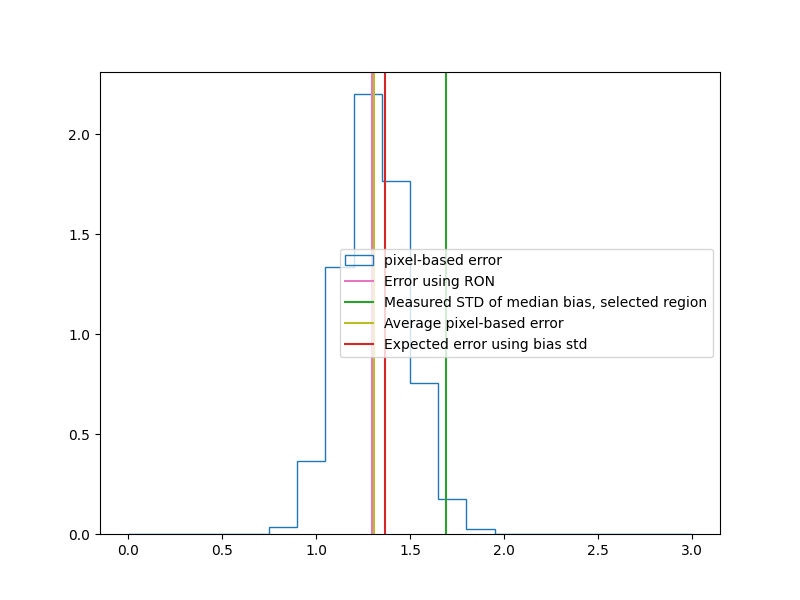

In [53]:
plt.figure(figsize=(8,6))
plt.hist(median_error.flatten(), bins=20, range = (0,3.), 
         density = True, histtype='step', label='pixel-based error')
plt.axvline(expected_noise_mbias, label = 'Error using RON', c = 'C6')
plt.axvline(measured_std_mbias, label = 'Measured STD of median bias, selected region', c = 'C2')
plt.axvline(median_pixel_error, label = 'Average pixel-based error', c = 'C8')
plt.axvline(expected_std_mbias, label = 'Expected error using bias std', c = 'C3')
plt.legend()
plt.show()

In [54]:
pickle.dump(median_bias, open('median_bias.p', 'wb'))
pickle.dump(median_error, open('median_bias_error.p', 'wb'))
pickle.dump(median_pixel_error, open('median_pixel_error.p', 'wb'))
pickle.dump(stack, open('stack_bias.p', 'wb'))